# Tutorial: Turn Detection

**Author:** Masoud Abedinifar

**Last update:** Thu 06 May 2024

## Learning Objectives
By the end of this tutorial:
- You can load data from a recording that belongs to one of the available datasets,
- Apply the Pham Turn Detection algorithm.
- Visualize the results of the algorithm.
- Extract spatio-temporal parameters of the detected turns.
- Interpret the detected turns for further analysis.

# Pham Turn Detection

This example can be referenced by citing the package.

The example illustrates how to use PhamTurnDetection algorithm to detect turns using acceleration and gyro data recorded with a lower back IMU sensor. The turn detection algorithm is implemented using [`ngmt.modules.td._pham`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/td/_pham.py). This algorithm is based on the research of Pham et al [`1`].

This algorithm aims to detect turns using accelerometer and gyroscope data collected from a lower back inertial measurement unit (IMU) sensor. The core of the algorithm lies in the detect method, where turns are identified using accelerometer and gyroscope data. The method first processes the gyro data, converting it to rad/s and computing the variance to identify periods of low variance, which may indicate bias. It then calculates the gyro bias and subtracts it from the original gyro signal to remove any biases. Next, the yaw angle is computed by integrating the gyro data, and zero-crossings indices are found to detect turns. Then, turns are identified based on significant changes in the yaw angle.

The algorithm also accounts for hesitations, which are brief pauses or fluctuations in the signal that may occur within a turn. Hesitations are marked based on specific conditions related to the magnitude and continuity of the yaw angle changes.

Then, the detected turns are characterized by their onset and duration. Turns with angles equal to or greater than 90 degrees and durations between 0.5 and 10 seconds are selected for further analysis. Finally, the detected turns along with their characteristics (onset, duration, etc.) are stored in a pandas DataFrame (`turns_` attribute).

In addition, spatial-temporal parameters are calculated using detected turns and their characteristics by the `spatio_temporal_parameters` method. As a return, the turn id along with its spatial-temporal parameters including direction (left or right), angle of turn and peak angular velocity are stored in a pandas DataFrame (`parameters_` attribute).

Optionally, if `plot_results` is set to True, the algorithm generates a plot visualizing the accelerometer and gyroscope data alongside the detected turns. This visualization aids in the qualitative assessment of the algorithm's performance and provides insights into the dynamics of the detected turns.

#### References
[`1`] Pham et al. (2017). Algorithm for Turning Detection and Analysis Validated under Home-Like Conditions in Patients with Parkinson's Disease and Older Adults using a 6 Degree-of-Freedom Inertial Measurement Unit at the Lower Back. Frontiers in Neurology, 8, 135. https://doi.org/10.3389/fneur.2017.00135

## Import Libraries
The necessary libraries such as numpy, matplotlib.pyplot, dataset and PhamTurnDetection turn detection algortihm are imported. Make sure that you have all the required libraries and modules installed before running this code. You also may need to install the `ngmt` library and its dependencies if you haven't already.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ngmt.datasets import keepcontrol
from ngmt.modules.td import PhamTurnDetection

## Data Preparation

To implement Pham Turn Detection algorithm, we load example data.


In [2]:
# The 'file_path' variable holds the absolute path to the data file
file_path = r"\Data\sub-pp002_task-walkTurn_tracksys-imu_motion.tsv"

In [3]:
# In this example, we use "imu" as tracking_system and "pelvis" as tracked points.
tracking_sys = "imu"
tracked_points = {tracking_sys: ["pelvis"]}

In [4]:
# The 'keepcontrol.load_recording' function is used to load the data from the specified file_path
recording = keepcontrol.load_recording(
    file_name=file_path, tracking_systems=[tracking_sys], tracked_points=tracked_points
)

In [5]:
# Load lower back acceleration data
accel_data = recording.data[tracking_sys][
    ["pelvis_ACC_x", "pelvis_ACC_y", "pelvis_ACC_z"]
]

# Get the acceleration data unit from the recording
accel_unit = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"].str.contains("ACC", case=False)
]["units"].iloc[0]

# Print acceleration data
print(f"acceleration_data ({accel_unit}): {accel_data}")

acceleration_data (g):       pelvis_ACC_x  pelvis_ACC_y  pelvis_ACC_z
0         0.983901     -0.032714      0.164542
1         0.992177     -0.027832      0.171870
2         0.993660     -0.026852      0.163584
3         0.991220     -0.025391      0.171870
4         0.984858     -0.030754      0.167977
...            ...           ...           ...
7141      0.984380      0.115229      0.228036
7142      0.982897      0.116690      0.218751
7143      0.966298      0.100583      0.217772
7144      0.957019      0.091299      0.211923
7145      0.957019      0.089839      0.211423

[7146 rows x 3 columns]


In [6]:
# Load lower back gyro data
gyro_data = recording.data[tracking_sys][
    ["pelvis_ANGVEL_x", "pelvis_ANGVEL_y", "pelvis_ANGVEL_z"]
]

# Get the gyro data unit from the recording
gyro_unit = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"].str.contains("ANGVEL", case=False)
]["units"].iloc[0]

# Print gyro data
print(f"gyro_data ({gyro_unit}): {gyro_data}")

gyro_data (deg/s):       pelvis_ANGVEL_x  pelvis_ANGVEL_y  pelvis_ANGVEL_z
0            0.351765        -0.437449        -0.087013
1           -0.087941        -0.698968         0.174026
2            0.698645        -1.573867        -0.174026
3            0.087941        -1.661039        -0.786015
4            0.874528        -0.611795        -0.350952
...               ...              ...              ...
7141        15.560731       -17.223774        -0.699003
7142        16.699083       -17.310947        -0.261038
7143        18.272255       -17.574051         0.524977
7144        18.970900       -18.185846         1.922982
7145        21.071722       -16.786325         2.534972

[7146 rows x 3 columns]


In [7]:
# Get the corresponding sampling frequency directly from the recording
sampling_frequency = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"] == "pelvis_ACC_x"
]["sampling_frequency"].values[0]

# Print sampling frequency
print(f"sampling frequency: {sampling_frequency} Hz")

sampling frequency: 200 Hz


## Visualisation of the Data
The raw acceleration and gyro data including components of x, y and z axis are plotted.

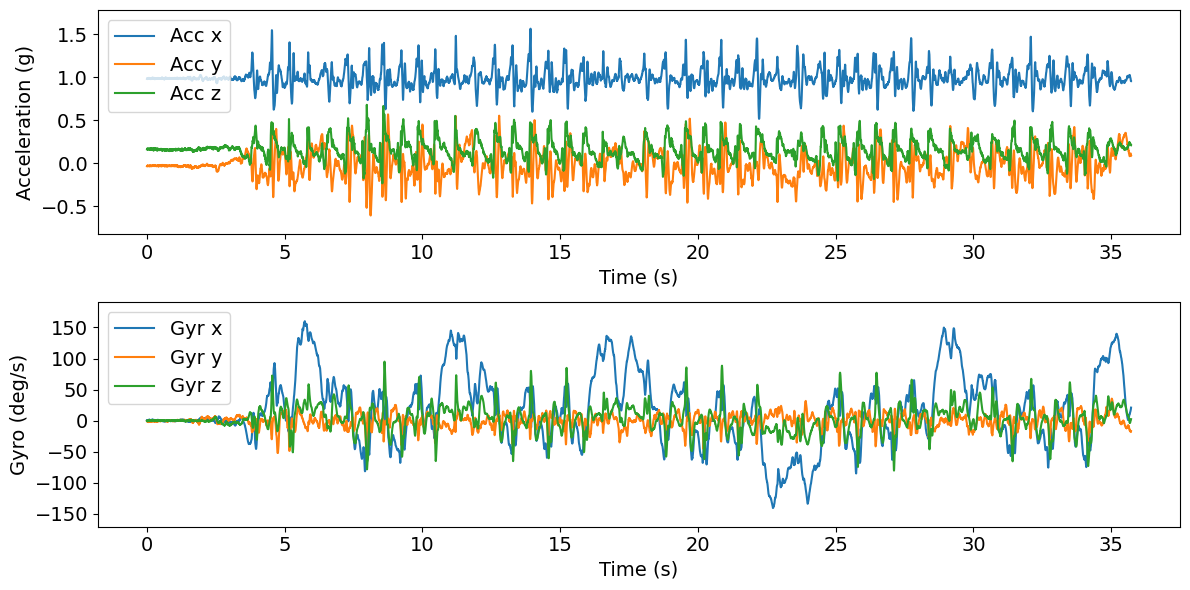

In [8]:
# Plot acceleration and gyro in subplots
fig = plt.figure(figsize=(12, 6))

# Font size for all text elements
font_size = 14

# Subplot 1: Acceleration data
ax1 = plt.subplot(211)
for i in range(3):
    ax1.plot(
        np.arange(len(accel_data)) / sampling_frequency,
        accel_data[f"pelvis_ACC_{chr(120 + i)}"],
        label=f"Acc {'xyz'[i]}",
    )
ax1.set_ylabel(f"Acceleration ({accel_unit})", fontsize=font_size)
ax1.set_xlabel(f"Time (s)", fontsize=font_size)
ax1.legend(loc="upper left", fontsize=font_size)
accel_min = np.min(accel_data)
accel_max = np.max(accel_data)
buffer = (accel_max - accel_min) * 0.1
ax1.set_ylim(accel_min - buffer, accel_max + buffer)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Subplot 2: Gyro data
ax2 = plt.subplot(212)
for i in range(3):
    ax2.plot(
        np.arange(len(gyro_data)) / sampling_frequency,
        gyro_data[f"pelvis_ANGVEL_{chr(120 + i)}"],
        label=f"Gyr {'xyz'[i]}",
    )
ax2.set_ylabel(f"Gyro ({gyro_unit})", fontsize=font_size)
ax2.set_xlabel(f"Time (s)", fontsize=font_size)
ax2.legend(loc="upper left", fontsize=font_size)
gyro_min = np.min(gyro_data)
gyro_max = np.max(gyro_data)
buffer = (gyro_max - gyro_min) * 0.1
ax2.set_ylim(gyro_min - buffer, gyro_max + buffer)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
fig.tight_layout()
plt.show()

## Applying Pham Turn Detection Algorithm
Now, we are running Pham turn detection algorithm from pham module [`NGMT.ngmt.modules.td._pham.PhamTurnDetection`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/td/_pham.py) to detect turns.

The following code first prepares the input data by combining acceleration and gyro data into a single DataFrame called `input_data`.

Then, in order to apply turn detection algorithm, an instance of the PhamTurnDetection class is created using the constructor, `PhamTurnDetection()`. The `pham` variable holds this instance, allowing us to access its methods. The inputs of the algorithm are as follows:

- **Data:** `data (pd.DataFrame)` includes accelerometer and gyro data (N, 6) for x, y, and z axes. in pandas Dataframe format.
- **Vertical gyro:** `gyro_vertical (str)` corresponds to the name of the vertical component of gyro.
- **Unit of acceleration data:** `accel_unit (str)` is the unit of the acceleation data.
- **Unit of gyro data:** `gyro_unit (str)` is unit of the gyro data.
- **Sampling Frequency:** `sampling_freq_Hz` is the sampling frequency of the data, defined in Hz.
- **Datetime:** `dt_data (pd.Series, optional)` is the original datetime in the input data which is optional.
- **Tracking system:** `tracking_system (str, optional)` is the name of tracking system which is optional.
- **Tracked Point:** `tracked_point (str, optional)` is the tracked point name on the body which is optional.
- **Plot Results:** `plot_results (bool, optional)`, if set to True, generates a plot showing the detected turns on the data. The default is False. The onset is represented with the vertical red line and the grey area represents the duration of the turns detected by the algorithm.

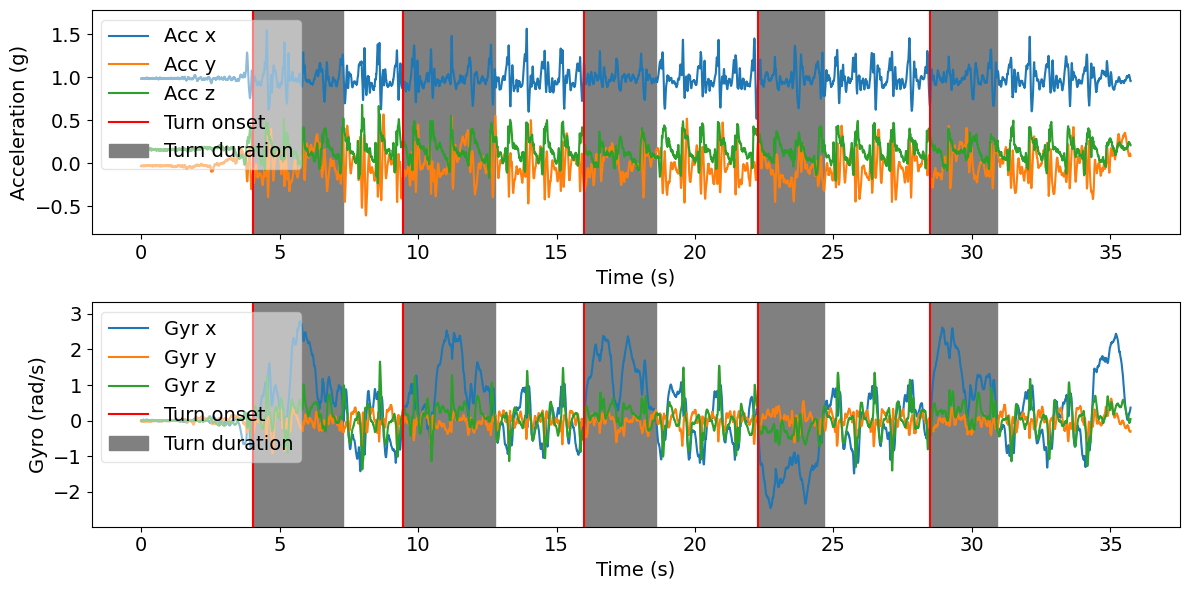

In [9]:
# Put acceleration and gyro data in the input data as pandas Dataframe which will be used as input of the algorithm
input_data = [accel_data, gyro_data]

# Concatenate acceleration_data and gyro_data along axis=1 (columns)
input_data = pd.concat([accel_data, gyro_data], axis=1)

# Create an instance of the PhamTurnDetection class
pham = PhamTurnDetection()

# Call the turn detection using pham.detect
pham = pham.detect(
    data=input_data,
    gyro_vertical="pelvis_ANGVEL_x",
    accel_unit=accel_unit,
    gyro_unit=gyro_unit,
    sampling_freq_Hz=sampling_frequency,
    tracking_system="imu",
    tracked_point="pelvis",
    plot_results=True,
)

The outputs are stored in the `turns_` attribute, which is a pandas DataFrame in BIDS format with the following columns:

- **onset**: Start of the turn event in seconds.
- **duration**: Duration of the turn event in seconds.
- **event_type**: Type of event which is turn.
- **tracking_systems**: Tracking system which is 'imu' for this example.
- **tracked_points**: Tracked points on the body which is 'pelvis' for this example.

In [10]:
# Print events and their corresponding information
print(f"turn events: {pham.turns_}")

turn events:     onset  duration event_type tracking_systems tracked_points
0   4.045     3.260       turn              imu         pelvis
1   9.440     3.350       turn              imu         pelvis
2  15.990     2.615       turn              imu         pelvis
3  22.260     2.390       turn              imu         pelvis
4  28.495     2.410       turn              imu         pelvis


## Extraction of Spatio-temporal Parameters

Next, the spatial-temporal parameters could be extracted using the spatio_temporal_parameters method. The outputs are stored in the `parameters_` attribute, which is a pandas DataFrame and icnlues trun id along with the following parameters:

- **direction_of_turn**: Direction of turn which is either "left" or "right".
- **angle_of_turn**: Angle of turn in degrees.
- **peak_angular_velocity**: Peak angular velocity in deg/s.


In [11]:
# Call the spatio-temporal parameters object for extracting the temporal parameters
pham.spatio_temporal_parameters()

# Print temporal parameters for each turn
print(pham.parameters_)

        direction_of_turn  angle_of_turn  peak_angular_velocity
turn id                                                        
0                   right     197.342112             159.389042
1                   right     199.467175             144.612453
2                   right     201.117562             136.045498
3                    left    -199.244817             140.544659
4                   right     187.771228             149.070591
